In [1]:
import numpy as np 
import os 
import matplotlib.pyplot as plt 
import seaborn as sns
import pandas as pd 
from myheatmap import myheatmap
import matplotlib as mpl
import scipy as sp

print(mpl.__version__) # version 3 required for cmap='twilight_shifted'

sns.set_context('poster') # makes text larger

add_circle = False
plot3d = False


"""# colormaps: PiYG, vlag_r, bwr_r, RdBu, Seismic_r
divergingcmap = 'vlag_r'
cmapforhalf = 'vlag'"""


# source: https://stackoverflow.com/questions/7404116/defining-the-midpoint-of-a-colormap-in-matplotlib
class MidpointNormalize(mpl.colors.Normalize):
    def __init__(self, vmin, vmax, midpoint=0, clip=False):
        self.midpoint = midpoint
        mpl.colors.Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        normalized_min = max(0, 1 / 2 * (1 - abs((self.midpoint - self.vmin) / (self.midpoint - self.vmax))))
        normalized_max = min(1, 1 / 2 * (1 + abs((self.vmax - self.midpoint) / (self.midpoint - self.vmin))))
        normalized_mid = 0.5
        x, y = [self.vmin, self.midpoint, self.vmax], [normalized_min, normalized_mid, normalized_max]
        return sp.ma.masked_array(sp.interp(value, x, y))


3.1.2


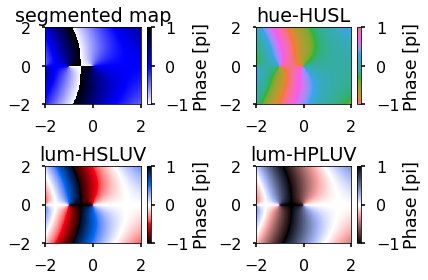

In [2]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as col
import seaborn as sns
import hsluv # pip install hsluv
import scipy.special # just for the example function

##### generate custom colormaps
def shiftedColorMap(cmap, min_val, max_val, name):
    '''Function to offset the "center" of a colormap. Useful for data with a negative min and positive max and you want the middle of the colormap's dynamic range to be at zero. Adapted from https://stackoverflow.com/questions/7404116/defining-the-midpoint-of-a-colormap-in-matplotlib

    Input
    -----
      cmap : The matplotlib colormap to be altered.
      start : Offset from lowest point in the colormap's range.
          Defaults to 0.0 (no lower ofset). Should be between
          0.0 and `midpoint`.
      midpoint : The new center of the colormap. Defaults to
          0.5 (no shift). Should be between 0.0 and 1.0. In
          general, this should be  1 - vmax/(vmax + abs(vmin))
          For example if your data range from -15.0 to +5.0 and
          you want the center of the colormap at 0.0, `midpoint`
          should be set to  1 - 5/(5 + 15)) or 0.75
      stop : Offset from highets point in the colormap's range.
          Defaults to 1.0 (no upper ofset). Should be between
          `midpoint` and 1.0.'''
    epsilon = 0.001
    start, stop = 0.0, 1.0
    min_val, max_val = min(0.0, min_val), max(0.0, max_val) # Edit #2
    midpoint = 1.0 - max_val/(max_val + abs(min_val))
    cdict = {'red': [], 'green': [], 'blue': [], 'alpha': []}
    # regular index to compute the colors
    reg_index = np.linspace(start, stop, 257)
    # shifted index to match the data
    shift_index = np.hstack([np.linspace(0.0, midpoint, 128, endpoint=False), np.linspace(midpoint, 1.0, 129, endpoint=True)])
    for ri, si in zip(reg_index, shift_index):
        if abs(si - midpoint) < epsilon:
            r, g, b, a = cmap(0.5) # 0.5 = original midpoint.
        else:
            r, g, b, a = cmap(ri)
        cdict['red'].append((si, r, r))
        cdict['green'].append((si, g, g))
        cdict['blue'].append((si, b, b))
        cdict['alpha'].append((si, a, a))
    newcmap = matplotlib.colors.LinearSegmentedColormap(name, cdict)
    plt.register_cmap(cmap=newcmap)
    return newcmap
def make_segmented_cmap(): 
    white = '#ffffff'
    black = '#000000'
    red = '#ff0000'
    blue = '#0000ff'
    anglemap = col.LinearSegmentedColormap.from_list(
        'anglemap', [black, red, white, blue, black], N=256, gamma=1)
    return anglemap

def make_anglemap( N = 256, use_hpl = True ):
    h = np.ones(N) # hue
    h[:N//2] = 11.6 # red 
    h[N//2:] = 258.6 # blue
    s = 100 # saturation
    l = np.linspace(0, 100, N//2) # luminosity
    l = np.hstack( (l,l[::-1] ) )

    colorlist = np.zeros((N,3))
    for ii in range(N):
        if use_hpl:
            colorlist[ii,:] = hsluv.hpluv_to_rgb( (h[ii], s, l[ii]) )
        else:
            colorlist[ii,:] = hsluv.hsluv_to_rgb( (h[ii], s, l[ii]) )
    colorlist[colorlist > 1] = 1 # correct numeric errors
    colorlist[colorlist < 0] = 0 
    return col.ListedColormap( colorlist )

N = 256
segmented_cmap = make_segmented_cmap()
flat_huslmap = col.ListedColormap(sns.color_palette('husl',N))
hsluv_anglemap = make_anglemap( use_hpl = False )
hpluv_anglemap = make_anglemap( use_hpl = True )

##### generate data grid
x = np.linspace(-2,2,N)
y = np.linspace(-2,2,N)
z = np.zeros((len(y),len(x))) # make cartesian grid
for ii in range(len(y)): 
    z[ii] = np.arctan2(y[ii],x) # simple angular function
    z[ii] = np.angle(scipy.special.gamma(x+1j*y[ii])) # some complex function

##### plot with different colormaps
fig = plt.figure(1)
fig.clf()
colormapnames = ['segmented map', 'hue-HUSL', 'lum-HSLUV', 'lum-HPLUV']
colormaps = [shiftedColorMap(segmented_cmap,.5,1,'phase'), flat_huslmap, hsluv_anglemap, hpluv_anglemap]
halfangle = shiftedColorMap(hsluv_anglemap,.5,1,'phase')
for ii, cm in enumerate(colormaps):
    ax = fig.add_subplot(2, 2, ii+1)
    pmesh = ax.pcolormesh(x, y, z/np.pi, 
        cmap = cm, vmin=-1, vmax=1)
    plt.axis([x.min(), x.max(), y.min(), y.max()])
    cbar = fig.colorbar(pmesh)
    cbar.ax.set_ylabel('Phase [pi]')
    ax.set_title( colormapnames[ii] )
plt.tight_layout();
plt.show()

In [3]:
divergingcmap = hsluv_anglemap
cmapforhalf = hsluv_anglemap

C:\Users\vhorowit\AppData\Local\conda\conda\envs\py36\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


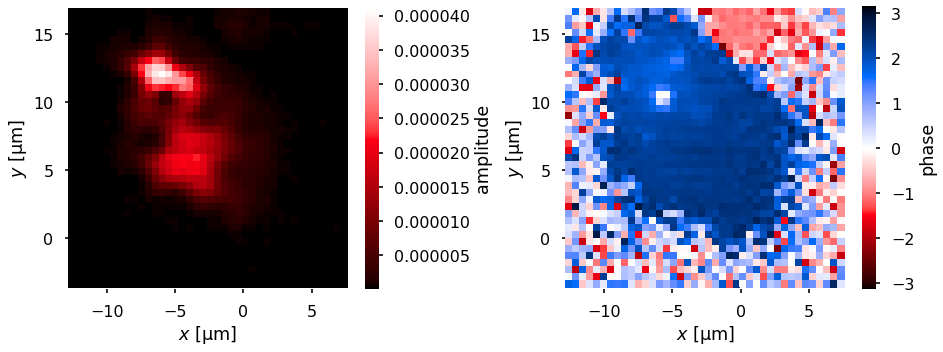

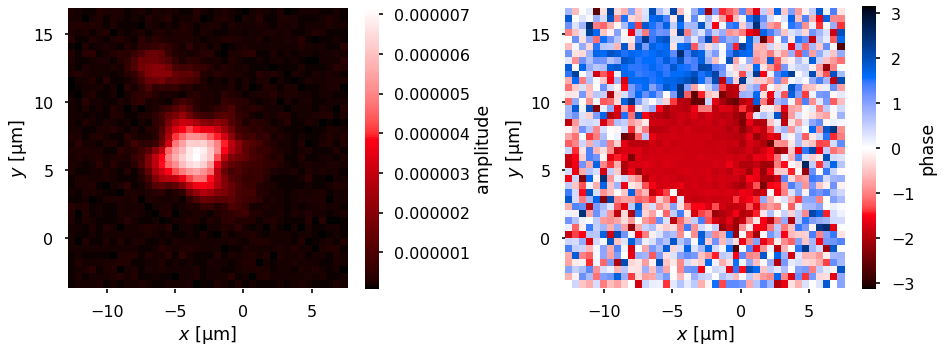

In [4]:
############### Mac vs Windows ##############
#folder1 = '/Volumes/Aleman-Lab/Group/Projects/GrapheneCoupledResonators/Data/Sample2/2019/2019/08/09/'
#folder2 = '/Volumes/Aleman-Lab/Group/Projects/GrapheneCoupledResonators/Data/Sample2/2019/07/30/'
folder1 = r'\\cas-fs1.uoregon.edu\Material-Science-Institute\Aleman-Lab\Group\Projects\GrapheneCoupledResonators\Data\Sample2\2019\2019\08\09'
folder2 = r'\\cas-fs1.uoregon.edu\Material-Science-Institute\Aleman-Lab\Group\Projects\GrapheneCoupledResonators\Data\Sample2\2019\07\30'

file = 'PosGU01Array01.00r0.5p3Array01.00r0.5p3Device1.2Drum_15.16MHz_1104325' 
path = os.path.join(folder1,file)
df = pd.read_csv(os.path.join(path, 'Demod1.csv'), skiprows = 2) 
df['X um']=df['Green X']
df['Y um']= df['Green Y']

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(13.23,5))

#plt.suptitle(file + '\n\n');

plt.sca(ax1)
amp1 = df.pivot_table(index = 'Y um', columns = 'X um', values = 'r').sort_index(axis = 0, ascending = False) 
data = (amp1)
# set white at max, cut colorbar in half
vmin = np.array(data).min()
vmax = np.array(data).max()
greennorm = MidpointNormalize(vmin=vmin, vmax=vmax, midpoint=vmax)

myheatmap(data, 'amplitude', norm = greennorm,
          cmap=cmapforhalf);
plt.xlabel(u'$x$ [μm]')
plt.ylabel(u'$y$ [μm]')
ax1.axis('equal')


plt.sca(ax2) 
phase1 = df.pivot_table(index = 'Y um', columns = 'X um', values = 'phase').sort_index(axis = 0, ascending = False) 
myheatmap(phase1, 'phase', vmin=-np.pi, vmax = np.pi, cmap=divergingcmap);
ax2.axis('equal');
plt.xlabel(u'$x$ [μm]')
plt.ylabel(u'$y$ [μm]')
plt.tight_layout();


file = 'PosGU01Array01.00r0.5p3Array01.00r0.5p3Device1.2Drum1_15.5MHz105133' 
path = os.path.join(folder1,file)
df = pd.read_csv(os.path.join(path, 'Demod1.csv'), skiprows = 2) 
df['X um']=df['Green X']
df['Y um']= df['Green Y']

fig, (ax3, ax4) = plt.subplots(1, 2, figsize=(13.23,5))

plt.sca(ax3)
amp2 = df.pivot_table(index = 'Y um', columns = 'X um', values = 'r').sort_index(axis = 0, ascending = False) 
data = amp2
# set white at max, cut colorbar in half
vmin = np.array(data).min()
vmax = np.array(data).max()
greennorm = MidpointNormalize(vmin=vmin, vmax=vmax, midpoint=vmax)

myheatmap(data, 'amplitude', norm = greennorm,
          cmap=cmapforhalf);
plt.xlabel(u'$x$ [μm]')
plt.ylabel(u'$y$ [μm]')
ax3.axis('equal');

if add_circle:
    circle1 = plt.Circle((-6.8, 7.6), 1, color='w', alpha = .3)
    circle2 = plt.Circle((-2.9,9.9), 1, color='w', alpha = .3)
    circle3 = plt.Circle((-1,5), 1, color='w', alpha = .3)
    ax3.add_artist(circle1)
    ax3.add_artist(circle2)
    ax3.add_artist(circle3)

plt.sca(ax4) 
phase2 = df.pivot_table(index = 'Y um', columns = 'X um', values = 'phase').sort_index(axis = 0, ascending = False) 
myheatmap(phase2, 'phase', vmin=-np.pi, vmax = np.pi, cmap=divergingcmap);
plt.xlabel(u'$x$ [μm]')
plt.ylabel(u'$y$ [μm]')
ax4.axis('equal');

plt.tight_layout();

C:\Users\vhorowit\AppData\Local\conda\conda\envs\py36\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars
C:\Users\vhorowit\AppData\Local\conda\conda\envs\py36\lib\site-packages\ipykernel_launcher.py:57: RuntimeWarning: divide by zero encountered in log
C:\Users\vhorowit\AppData\Local\conda\conda\envs\py36\lib\site-packages\ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in log
C:\Users\vhorowit\AppData\Local\conda\conda\envs\py36\lib\site-packages\ipykernel_launcher.py:64: RuntimeWarning: divide by zero encountered in log
C:\Users\vhorowit\AppData\Local\conda\conda\envs\py36\lib\site-packages\ipykernel_launcher.py:64: RuntimeWarning: invalid value encountered in log
C:\Users\vhorowit\AppData\Local\conda\conda\envs\py36\lib\site-packages\ipykernel_launcher.py:123: RuntimeWarning: divide by zero encountered in log
C:\Users\vhorowit\AppData\Local\conda\conda\envs\py36\lib\site-packages\ipykernel_launcher.py:123: Run

(-12.864876223500001, 7.647944289499999, -3.592391968, 16.922208319)

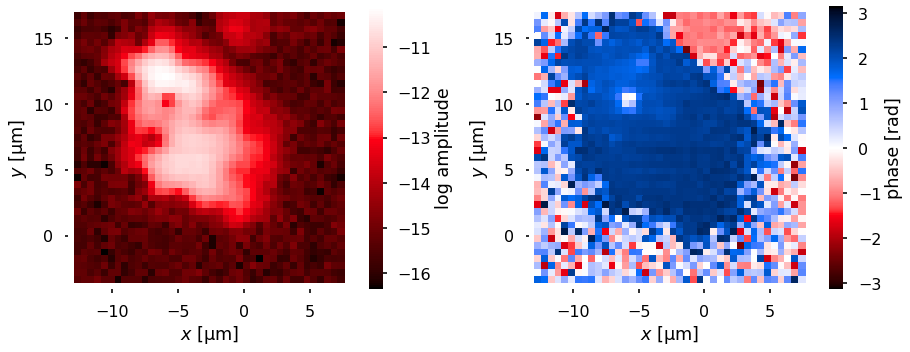

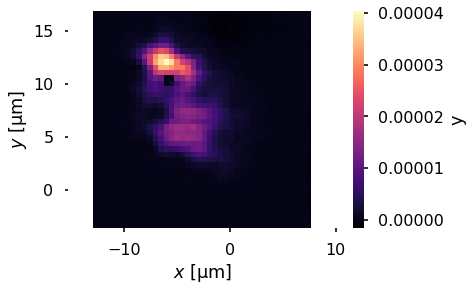

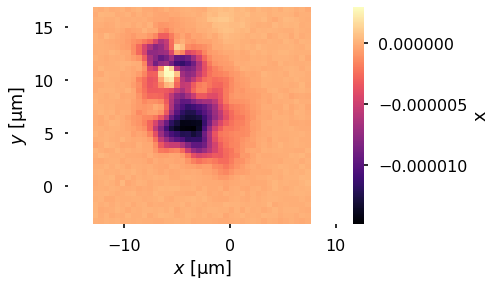

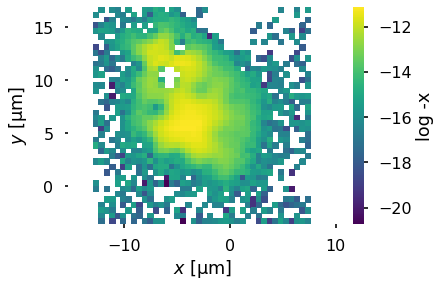

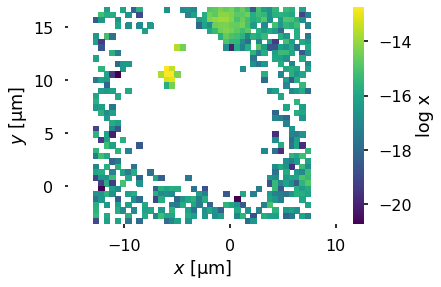

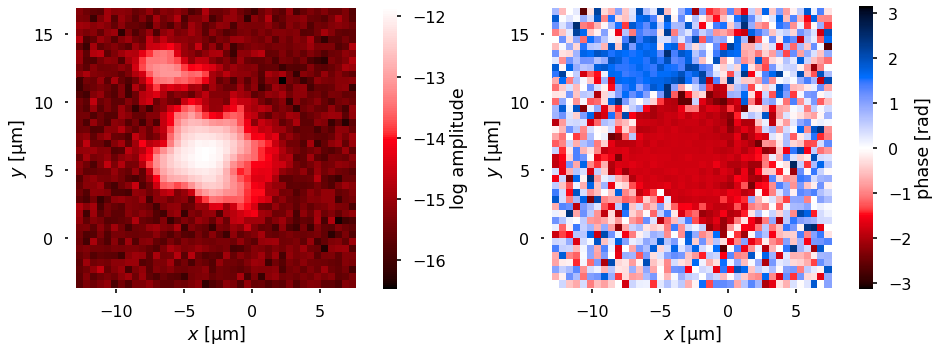

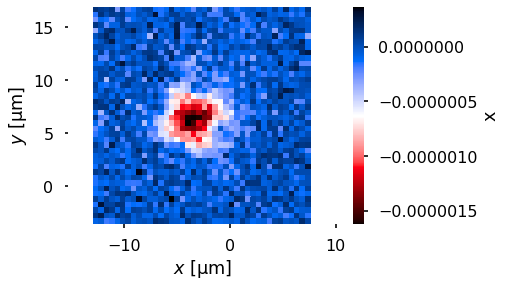

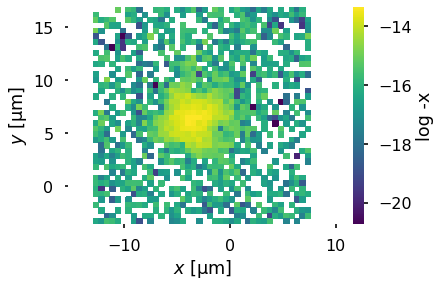

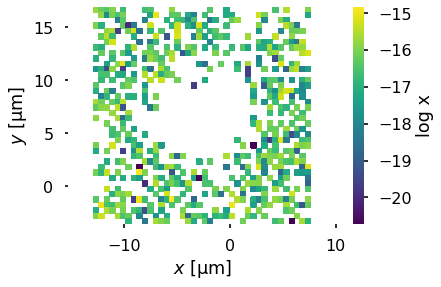

In [5]:
file = 'PosGU01Array01.00r0.5p3Array01.00r0.5p3Device1.2Drum_15.16MHz_1104325' 
path = os.path.join(folder1,file)
df = pd.read_csv(os.path.join(path, 'Demod1.csv'), skiprows = 2) 
#df.r = df.r/df.r.max() 
#print(df) 

df['X um']=df['Green X']
df['Y um']= df['Green Y']

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12.8,5))

#plt.suptitle(file + '\n\n');

plt.sca(ax1) 

amp1 = df.pivot_table(index = 'Y um', columns = 'X um', values = 'r').sort_index(axis = 0, ascending = False) 
data = np.log(amp1)
# set white at max, cut colorbar in half
vmin = np.array(data).min()
vmax = np.array(data).max()
greennorm = MidpointNormalize(vmin=vmin, vmax=vmax, midpoint=vmax)

myheatmap(data, 'log amplitude', norm = greennorm,
          cmap=cmapforhalf);
plt.xlabel(u'$x$ [μm]')
plt.ylabel(u'$y$ [μm]')
ax1.axis('equal')


plt.sca(ax2) 
phase1 = df.pivot_table(index = 'Y um', columns = 'X um', values = 'phase').sort_index(axis = 0, ascending = False) 
myheatmap(phase1, 'phase [rad]', vmin=-np.pi, vmax = np.pi, cmap=divergingcmap);
ax2.axis('equal');
plt.xlabel(u'$x$ [μm]')
plt.ylabel(u'$y$ [μm]')
plt.tight_layout();

plt.figure()
y1 = df.pivot_table(index = 'Y um', columns = 'X um', values = 'y').sort_index(axis = 0, ascending = False) 

myheatmap(y1, 'y') 
#          cmap=divergingcmap);
plt.xlabel(u'$x$ [μm]')
plt.ylabel(u'$y$ [μm]')
plt.gca().axis('equal')

plt.figure()
x1 = df.pivot_table(index = 'Y um', columns = 'X um', values = 'x').sort_index(axis = 0, ascending = False) 

myheatmap(x1, 'x') 
#          cmap=divergingcmap);
plt.xlabel(u'$x$ [μm]')
plt.ylabel(u'$y$ [μm]')
plt.gca().axis('equal')

plt.figure()
myheatmap(np.log(-x1), 'log -x', 
          cmap='viridis');
plt.xlabel(u'$x$ [μm]')
plt.ylabel(u'$y$ [μm]')
plt.gca().axis('equal')

plt.figure()
myheatmap(np.log(x1), 'log x', 
          cmap='viridis');
plt.xlabel(u'$x$ [μm]')
plt.ylabel(u'$y$ [μm]')
plt.gca().axis('equal')


file = 'PosGU01Array01.00r0.5p3Array01.00r0.5p3Device1.2Drum1_15.5MHz105133' 
path = os.path.join(folder1,file)
df = pd.read_csv(os.path.join(path, 'Demod1.csv'), skiprows = 2) 
#df.r = df.r/df.r.max() 
#print(df) 
df['X um']=df['Green X']
df['Y um']= df['Green Y']


fig, (ax3, ax4) = plt.subplots(1, 2, figsize=(13.23,5))

plt.sca(ax3)
amp2 = df.pivot_table(index = 'Y um', columns = 'X um', values = 'r').sort_index(axis = 0, ascending = False) 
data = np.log(amp2)
# set white at max, cut colorbar in half
vmin = np.array(data).min()
vmax = np.array(data).max()
greennorm = MidpointNormalize(vmin=vmin, vmax=vmax, midpoint=vmax)

myheatmap(data, 'log amplitude', norm = greennorm,
          cmap=cmapforhalf);
plt.xlabel(u'$x$ [μm]')
plt.ylabel(u'$y$ [μm]')
ax3.axis('equal');

if add_circle:
    circle1 = plt.Circle((-6.8, 7.6), 1, color='w', alpha = .3)
    circle2 = plt.Circle((-2.9,9.9), 1, color='w', alpha = .3)
    circle3 = plt.Circle((-1,5), 1, color='w', alpha = .3)
    ax3.add_artist(circle1)
    ax3.add_artist(circle2)
    ax3.add_artist(circle3)

plt.sca(ax4)
phase2 = df.pivot_table(index = 'Y um', columns = 'X um', values = 'phase').sort_index(axis = 0, ascending = False) 
myheatmap(phase2, 'phase [rad]',vmin=-np.pi, vmax = np.pi, cmap=divergingcmap);
plt.xlabel(u'$x$ [μm]')
plt.ylabel(u'$y$ [μm]')
ax4.axis('equal');

plt.tight_layout();

plt.figure()
x1 = df.pivot_table(index = 'Y um', columns = 'X um', values = 'x').sort_index(axis = 0, ascending = False) 

myheatmap(x1, 'x', 
          cmap=divergingcmap);
plt.xlabel(u'$x$ [μm]')
plt.ylabel(u'$y$ [μm]')
plt.gca().axis('equal')

plt.figure()
myheatmap(np.log(-x1), 'log -x', 
          cmap='viridis');
plt.xlabel(u'$x$ [μm]')
plt.ylabel(u'$y$ [μm]')
plt.gca().axis('equal')

plt.figure()
myheatmap(np.log(x1), 'log x', 
          cmap='viridis');
plt.xlabel(u'$x$ [μm]')
plt.ylabel(u'$y$ [μm]')
plt.gca().axis('equal')

C:\Users\vhorowit\AppData\Local\conda\conda\envs\py36\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


PosGU01Arrray01.00r0.5p3Device0.1Drum2_10V114238


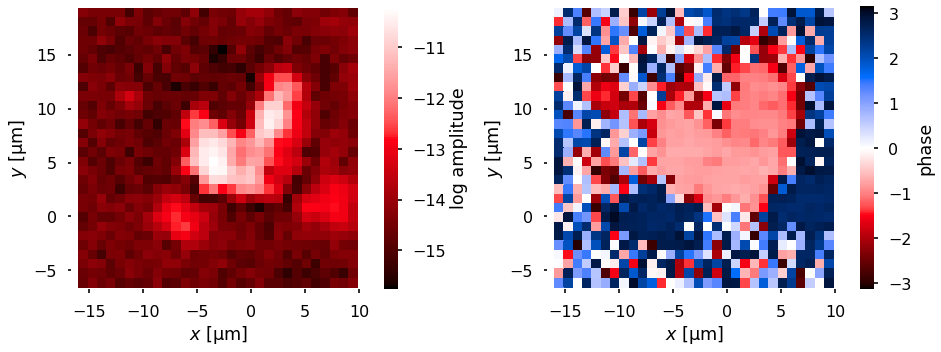

In [6]:
file = 'PosGU01Arrray01.00r0.5p3Device0.1Drum2_10V114238' 
path = os.path.join(folder2,file)
df = pd.read_csv(os.path.join(path, 'Demod1.csv'), skiprows = 2) 
df['X um']=df['Green X']
df['Y um']= df['Green Y']

fig, (ax1, ax2) = plt.subplots(1, 2,  figsize=(13.23,5))

#plt.suptitle(file + '\n\n');

plt.sca(ax1)
amp1 = df.pivot_table(index = 'Y um', columns = 'X um', values = 'r').sort_index(axis = 0, ascending = False) 
data = np.log(amp1)
# set white at max, cut colorbar in half
vmin = np.array(data).min()
vmax = np.array(data).max()
greennorm = MidpointNormalize(vmin=vmin, vmax=vmax, midpoint=vmax)

myheatmap(data, 'log amplitude', norm = greennorm,
          cmap=cmapforhalf);
plt.xlabel(u'$x$ [μm]')
plt.ylabel(u'$y$ [μm]')
ax1.axis('equal')


plt.sca(ax2) 
phase1 = df.pivot_table(index = 'Y um', columns = 'X um', values = 'phase').sort_index(axis = 0, ascending = False) 
myheatmap(phase1, 'phase',vmin=-np.pi, vmax = np.pi, cmap=divergingcmap);
ax2.axis('equal');
plt.xlabel(u'$x$ [μm]')
plt.ylabel(u'$y$ [μm]')

print(file)
plt.tight_layout();

C:\Users\vhorowit\AppData\Local\conda\conda\envs\py36\lib\site-packages\ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in log
  # Remove the CWD from sys.path while we load stuff.
C:\Users\vhorowit\AppData\Local\conda\conda\envs\py36\lib\site-packages\ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in log
  # Remove the CWD from sys.path while we load stuff.
C:\Users\vhorowit\AppData\Local\conda\conda\envs\py36\lib\site-packages\ipykernel_launcher.py:17: RuntimeWarning: divide by zero encountered in log
C:\Users\vhorowit\AppData\Local\conda\conda\envs\py36\lib\site-packages\ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in log


'plt.figure()\nmyheatmap(np.nanmax(np.array(-np.log(-x1)),np.array(np.log(x1)))'

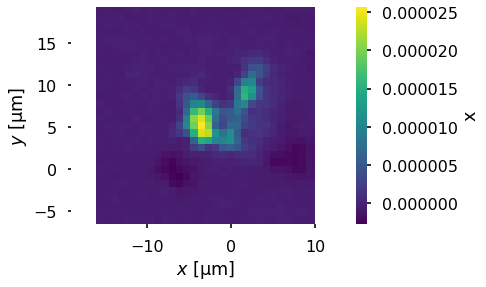

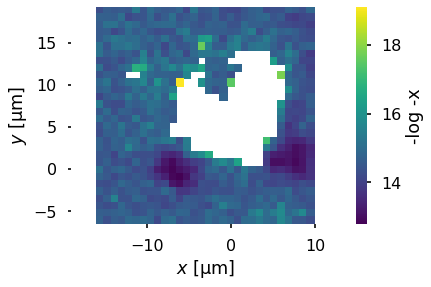

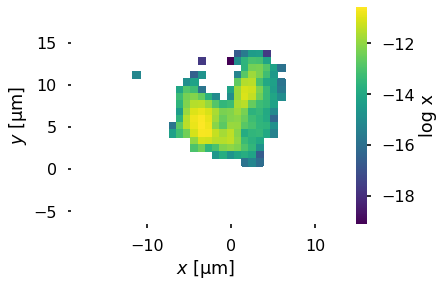

In [7]:
x1 = df.pivot_table(index = 'Y um', columns = 'X um', values = 'x').sort_index(axis = 0, ascending = False) 

myheatmap(x1, 'x', 
          cmap='viridis');
plt.xlabel(u'$x$ [μm]')
plt.ylabel(u'$y$ [μm]')
plt.gca().axis('equal')

plt.figure()
myheatmap(-np.log(-x1), '-log -x', 
          cmap='viridis');
plt.xlabel(u'$x$ [μm]')
plt.ylabel(u'$y$ [μm]')
plt.gca().axis('equal')

plt.figure()
myheatmap(np.log(x1), 'log x', 
          cmap='viridis');
plt.xlabel(u'$x$ [μm]')
plt.ylabel(u'$y$ [μm]')
plt.gca().axis('equal')

"""plt.figure()
myheatmap(np.nanmax(np.array(-np.log(-x1)),np.array(np.log(x1)))"""

In [8]:
#np.nanmax(np.array(-np.log(-x1)),np.array(np.log(x1)))

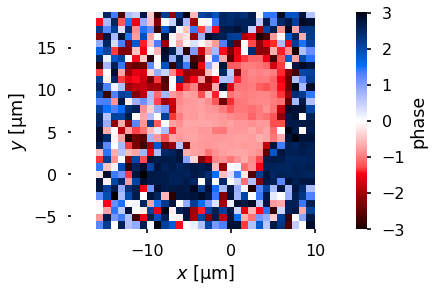

In [9]:

    
# set midpoint at zero.
vmin = np.array(phase1).min()
vmax = np.array(phase1).max()
norm = MidpointNormalize(vmin=vmin, vmax=vmax, midpoint=0)


## Plot with a norm at 0
myheatmap(phase1, 'phase', norm = norm,
          cmap=divergingcmap);
plt.gca().axis('equal');
plt.xlabel(u'$x$ [μm]')
plt.ylabel(u'$y$ [μm]');

In [10]:
if plot3d:
    from mpl_toolkits import mplot3d
    ax = plt.axes(projection='3d')
    X, Y = np.meshgrid(phase1.columns,phase1.index )
    ax.plot_surface(X,Y,phase1, 
                    norm=norm,  # set midpoint at 0.
                    antialiased=False,
                    cmap=divergingcmap )
    plt.xlabel(phase1.columns.name)
    plt.ylabel(phase1.index.name)
    ax.set_title(file);
    ax.view_init(elev=60., azim=0)

C:\Users\vhorowit\AppData\Local\conda\conda\envs\py36\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


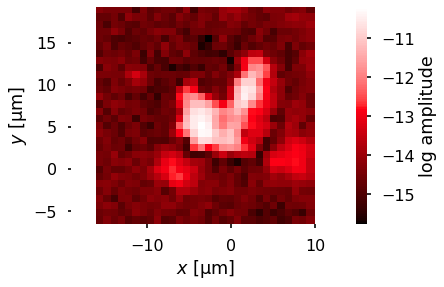

In [11]:
## Cut colorbar in half.

data = np.log(amp1)

# set white at max.
vmin = np.array(data).min()
vmax = np.array(data).max()
greennorm = MidpointNormalize(vmin=vmin, vmax=vmax, midpoint=vmax)


## Plot with a midpoint at 0.
myheatmap(data, 'log amplitude', norm = greennorm,
          cmap=cmapforhalf);
plt.gca().axis('equal');
plt.xlabel(u'$x$ [μm]')
plt.ylabel(u'$y$ [μm]');

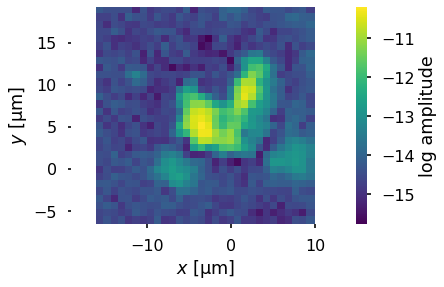

In [12]:
myheatmap(np.log(amp1), 'log amplitude', cmap = 'viridis');
plt.xlabel(u'$x$ [μm]')
plt.ylabel(u'$y$ [μm]')
plt.gca().axis('equal')

if plot3d:
    plt.figure()
    ax = plt.axes(projection='3d')
    X, Y = np.meshgrid(amp1.columns,amp1.index )
    ax.plot_surface(X,Y,(amp1), 
                    antialiased=False,
                    cmap='viridis', )
    plt.xlabel(amp1.columns.name)
    plt.ylabel(amp1.index.name)
    ax.set_title(file);
    ax.view_init(elev=60., azim=0)

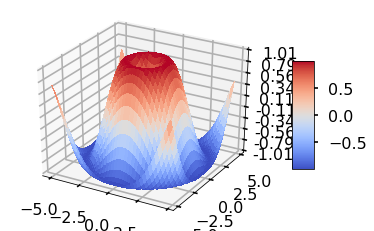

In [13]:
# This import registers the 3D projection, but is otherwise unused.
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 unused import

import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import numpy as np


fig = plt.figure()
ax = fig.gca(projection='3d')

# Make data.
X = np.arange(-5, 5, 0.25)
Y = np.arange(-5, 5, 0.25)
X, Y = np.meshgrid(X, Y)
R = np.sqrt(X**2 + Y**2)
Z = np.sin(R)

# Plot the surface.
surf = ax.plot_surface(X, Y, Z, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)

# Customize the z axis.
ax.set_zlim(-1.01, 1.01)
ax.zaxis.set_major_locator(LinearLocator(10))
ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))

# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=5)

plt.show()